In [2]:
from feos.si import *
from feos.dft import Pore3D, Adsorption3D, DFTSolver, FMTVersion, HelmholtzEnergyFunctional
from feos.pcsaft import PcSaftParameters

import pandas as pd
import numpy as np

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

import matplotlib.pyplot as plt

In [3]:
structure = Structure.from_file('structure_parameters/ZIF-8.cif')
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn12 H120 C96 N48
num_sites: 276


/home/bauer/opt/anaconda3/lib/python3.9/site-packages/pymatgen/io/cif.py:667: UserWarning: A 1-line symmetry op P1 CIF is detected!
  warnings.warn(msg)
/home/bauer/opt/anaconda3/lib/python3.9/site-packages/pymatgen/io/cif.py:1153: UserWarning: Issues encountered while parsing CIF: A 1-line symmetry op P1 CIF is detected!
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [4]:
coordinates = structure.cart_coords.T * ANGSTROM
system_size = [l * ANGSTROM for l in structure.lattice.lengths]

In [5]:
forcefield = pd.read_csv('structure_parameters/DREIDING.dat',delim_whitespace=True,names=["type","sigma","epsilon","mass"])
forcefield

,type,sigma,epsilon,mass
0,O,3.03300,48.1581,15.99900
1,C,3.47299,47.8562,12.01070
2,H,2.84600,7.6489,1.00784
3,N,3.26250,38.9492,14.00670
4,B,3.58100,47.8059,10.81100
5,Zn,1.33000,109.4710,65.38000


In [6]:
sigma = np.zeros(structure.num_sites)
epsilon = np.zeros(structure.num_sites)

mass = 0.0

for i, site in enumerate(structure):
    sigma[i] = forcefield["sigma"][forcefield["type"]==site.species_string]
    epsilon[i] = forcefield["epsilon"][forcefield["type"]==site.species_string]
    mass = mass + float(forcefield["mass"][forcefield["type"]==site.species_string]) * 1.6605402E-27

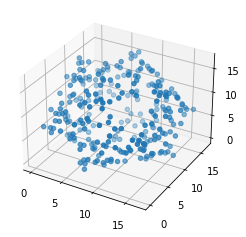

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=structure.cart_coords[:,0],ys=structure.cart_coords[:,1],zs=structure.cart_coords[:,2],s=20)

In [8]:
params = PcSaftParameters.from_json(['methane'], '../../parameters/pcsaft/gross2001.json')
func = HelmholtzEnergyFunctional.pcsaft(params, FMTVersion.AntiSymWhiteBear)

T = 303 * KELVIN

In [9]:
pore = Pore3D(system_size, [64, 64, 64], coordinates, sigma, epsilon)
pore.pore_volume

2.3689628728234253e-27 m³

In [10]:
solver = DFTSolver().picard_iteration(beta=0.01,max_iter=50).picard_iteration(beta=0.1,tol=1.0e-5).anderson_mixing(mmax=10,tol=1.0e-8)
solver

|solver|log|max_iter|tol|beta|mmax|max_rel|
|-|:-:|-:|-:|-:|-:|-:|
|Picard Iteration||50|1e-11|0.01||1|
|Picard Iteration||500|1e-5|0.1||1|
|Anderson Mixing||150|1e-8|0.15|10||

In [11]:
%%time
pressure = SIArray1.linspace(100*PASCAL, 50*BAR, 20)
isotherm = Adsorption3D.adsorption_isotherm(func, temperature = T, pressure = pressure, pore=pore, solver=solver)

CPU times: user 12min 37s, sys: 2min 46s, total: 15min 23s
Wall time: 15min 15s


Text(0, 0.5, 'N')

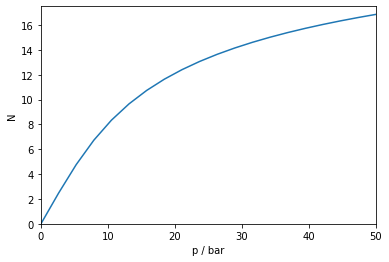

In [12]:
plt.plot(isotherm.pressure/BAR, isotherm.total_adsorption*NAV)
plt.axis([0,50,0,17.5])
plt.xlabel('p / bar')
plt.ylabel('N')